<a href="https://colab.research.google.com/github/Yug-Oswal/Yug/blob/main/HorsvHumwTL(InceptionV3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing all the required modules and libraries

import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
# Downloading the horse or human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Downloading the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [4]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



In [9]:
# Checking if files other than images exist
!find "{train_dir}" -type f ! -name "*.png"
!find "{validation_dir}" -type f ! -name "*.png"

Sample horse image:


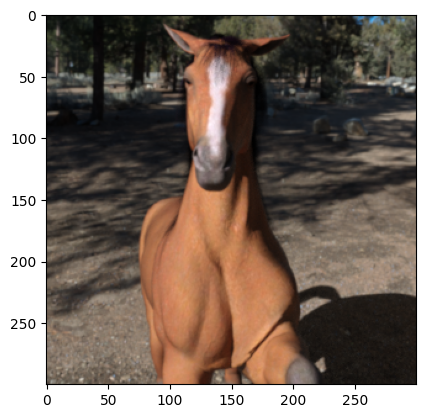


Sample human image:


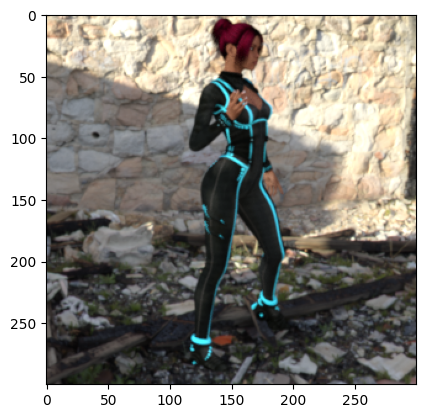

In [10]:
# Checking sample images

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [11]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

# Checking image shape
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


In [15]:
# Definining training and validation DirectoryIterator objects
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     rotation_range = 40,
                                     zoom_range = 0.2,
                                     shear_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(train_dir,
                                                      target_size = (150, 150),
                                                      batch_size = 32,
                                                      class_mode = 'binary')

  validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                target_size = (150, 150),
                                                                batch_size = 32,
                                                                class_mode = 'binary')

  return train_generator, validation_generator

In [16]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [17]:
# Checking the classes for reference
train_generator.class_indices

{'horses': 0, 'humans': 1}

In [18]:
# Downloading the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-24 17:06:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   139MB/s    in 0.6s    

2023-06-24 17:06:56 (139 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
# Defining a function to create a frozen and loaded pre-trained model
local_weights = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

def create_pre_trained_model(local_weights):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (150, 150, 3),
                                                         include_top = False,
                                                         weights = None)

  # Loading weights
  pre_trained_model.load_weights(local_weights)

  # Freezing all convolutional layers
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [26]:
pre_trained_model = create_pre_trained_model(local_weights)

# Checking model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [31]:
# Adding own DNN at the top

# Taking mixed7 as topmost or last_output layer to ensure generalization
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Defining Dense/Classification Network
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
# Adding Dropout for regularization
x = tf.keras.layers.Dropout(0.2)(x)
# Classifying
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.models.Model(inputs = pre_trained_model.input, outputs = output)

In [32]:
# Defining training params
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001), metrics = ['accuracy'])

In [33]:
# Defining a callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy') > 0.999):
      print("\nReached 99.9% accuracy. Stopping training.")
      self.model.stop_training = True

# Instantiating the callback
mycallback = myCallback()

In [34]:
history = model.fit(train_generator,
                    steps_per_epoch = 33,
                    epochs = 20,
                    validation_data = validation_generator,
                    validation_steps = 8,
                    verbose = 1,
                    callbacks = mycallback)

Epoch 1/20
33/33 [==============================] - 54s 2s/step - loss: 1.2025 - accuracy: 0.9172 - val_loss: 0.0232 - val_accuracy: 0.9961
Epoch 2/20
33/33 [==============================] - 53s 2s/step - loss: 0.0774 - accuracy: 0.9757 - val_loss: 0.0097 - val_accuracy: 0.9961
Epoch 3/20
33/33 [==============================] - 51s 2s/step - loss: 0.0834 - accuracy: 0.9718 - val_loss: 0.0572 - val_accuracy: 0.9883
Epoch 4/20
33/33 [==============================] - 51s 2s/step - loss: 0.0471 - accuracy: 0.9864 - val_loss: 0.0031 - val_accuracy: 0.9961
Epoch 5/20
33/33 [==============================] - 48s 1s/step - loss: 0.0662 - accuracy: 0.9844 - val_loss: 0.0148 - val_accuracy: 0.9961
Epoch 6/20
33/33 [==============================] - 51s 2s/step - loss: 0.0483 - accuracy: 0.9873 - val_loss: 0.0598 - val_accuracy: 0.9766
Epoch 7/20
33/33 [==============================] - 51s 2s/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.0098 - val_accuracy: 0.9961
Epoch 8/20
33/33 [==

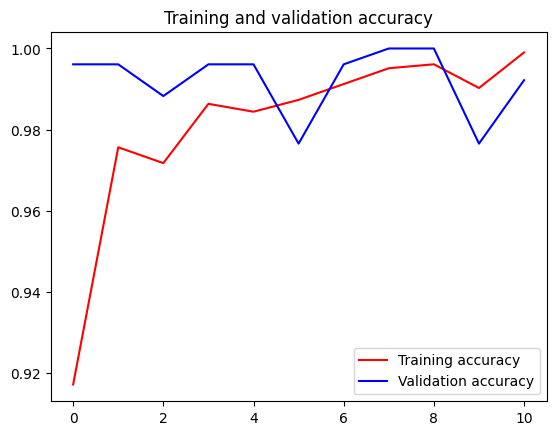

<Figure size 640x480 with 0 Axes>

In [35]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()